In [2]:
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.windows import from_bounds
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
from patchify import patchify

import torch
from torch.functional import F
from torch import nn
from torch.utils.data import DataLoader,TensorDataset
import fiona
from shapely.geometry import shape
import cv2
from pytorch_segmentation.inference import mosaic_to_raster
from pytorch_segmentation.data.inference_dataset import SatInferenceDataset
from pytorch_segmentation.utils.helper import shapes_intersecting_with_raster, raster_bounds_to_shape
#from pytorch_segmentation.utils.preprocessing import unpatchify,pad_image_topleft


seed = 42

device = torch.device('cpu')
#device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')


patch_size = [256,256,3] # [x,y,bands]
overlap = 128
padding = 64

bval = (255,255,255)
nworkers = 4
bs = 16


save_dir = "saved_models"


model_name = "unet_23_06_2022_155611"
data_parallel = True
model_path = save_dir + "/" + model_name +  ".pth" #unet_15_03_2022_071331.pth" #unet_24_03_2022_064749.pth
out_path = "data/out/"+model_name

In [ ]:
import segmentation_models_pytorch as smp

aux_params=dict(
    #pooling='avg',             # one of 'avg', 'max'
    dropout=0.5,
    classes=2
)

model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2
)

# SA

In [2]:
dataset_path = "data/datasets/inference_data.pkl"
data_path = "/home/jovyan/work/satellite_data/tmp/2018.vrt"

shape_path = "data/label_masks/dataset/test_norm.shp"
mask_path = "data/areas/test_normalization"



In [3]:
raster_bounds_to_shape(mask_path,shape_path)

/usr/local/lib/python3.8/dist-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# 1. Data Loading and Preprocessing

In [4]:

dataset = SatInferenceDataset(data_file_path=data_path,shape_file=shape_path,
                              shape_idx=[0],overlap=128,padding=64,transform=None)
shapes = dataset.shapes.copy()
dataset.save(dataset_path)

#del dataset


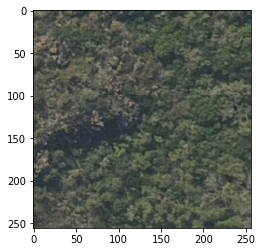

In [6]:
dataset.get_img(-300)

In [16]:
arr =  (dataset[-300][0] * 255).byte().numpy()
arr = arr.transpose(2,1,0)

In [7]:
arr.shape

(256, 256, 3)

In [17]:
import cv2

img = cv2.cvtColor(arr, cv2.COLOR_RGB2LAB)

In [18]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img[:,:,0] = clahe.apply(img[:,:,0])

# Converting image from LAB Color model to BGR color space
enhanced_img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
result = np.hstack((arr, enhanced_img))

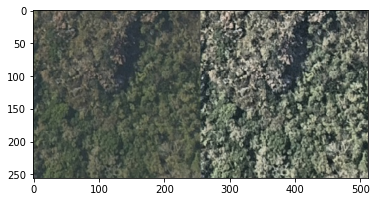

In [19]:
plt.imshow(result)

In [ ]:

cv2.imshow('Result', enhanced_img)

In [ ]:

loader = DataLoader(
    dataset,
    batch_size=100,
    num_workers=10,
    shuffle=False
) 


mean = 0.
std = 0.
nb_samples = 0.
for data in loader:
    batch_samples = data[0].size(0)
    data = data[0].view(batch_samples, data[0].size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(mean)
print(std)
tensor([0.5018, 0.4248, 0.3330])
tensor([0.0948, 0.0665, 0.0569])

In [5]:
mean = [0.5018, 0.4248, 0.3330]
std = [0.0948, 0.0665, 0.0569]

In [15]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.Normalize(mean=mean,
                            std=std) #for padded

])

# transform = transforms.Compose([
#     transforms.Normalize(mean=[0.3715, 0.3893, 0.3277]
#                          ,std=[0.0955, 0.0916, 0.0882])
# ])


In [16]:
t_dataset = SatInferenceDataset(data_file_path=data_path,shape_file=shape_path,
                              shape_idx=[0],overlap=128,padding=64,transform=transform)

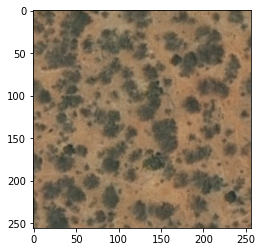

In [8]:
dataset.get_img(100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


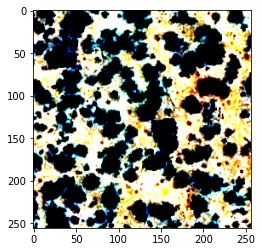

In [9]:
t_dataset.get_img(100)

# 2. UNet 


# 2.2 Unet

In [6]:
model_path = "saved_models/" + model_name +  ".pth"
state_dict = torch.load(model_path,map_location="cpu")

if data_parallel:
    # create new OrderedDict that does not contain `module.`
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] # remove `module.`
        new_state_dict[name] = v
    model_path = save_dir + "/" + model_name +  "_new.pth"
    torch.save(new_state_dict,model_path)

In [7]:
from pytorch_segmentation.models import UNet
net = UNet(n_channels=patch_size[2], n_classes=2, bilinear=False)

if data_parallel:
    net.load_state_dict(new_state_dict)
else:
    net.load_state_dict(state_dict)

net.eval();



# Multi Process Queue In-Memory

In [ ]:
from pytorch_segmentation.inference import mosaic_to_raster
mosaic_to_raster(dataset_path,shapes,net,out_path,device_ids=[0,1],
                bs=150,pin_memory=True,num_workers=5)

Total number of shapes:  5
Shape:  0
Queue PID:  17623


  0%|          | 0/112 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1


100%|██████████| 112/112 [00:06<00:00, 17.30it/s]


DONE  0
DONE  1
INFO: Written data/out/unet_23_06_2022_155611/test_sa_1.tif in 0.033 seconds
Shape:  1
Queue PID:  17623


  0%|          | 0/48 [00:00<?, ?it/s]

Start GPU: 1
Start GPU: 0


100%|██████████| 48/48 [00:05<00:00,  8.15it/s]


DONE  1
DONE  0
INFO: Written data/out/unet_23_06_2022_155611/test_sa_2.tif in 0.021 seconds
Shape:  2
Queue PID:  17623


  0%|          | 0/391 [00:00<?, ?it/s]

Start GPU: 1
Start GPU: 0


100%|██████████| 391/391 [00:09<00:00, 42.43it/s]

DONE  1
DONE  0


INFO: Written data/out/unet_23_06_2022_155611/test_sa_3.tif in 0.071 seconds
Shape:  3
Queue PID:  17623


  0%|          | 0/48 [00:00<?, ?it/s]

Start GPU: 1
Start GPU: 0


100%|██████████| 48/48 [00:05<00:00,  8.18it/s]


DONE  1
DONE  0
INFO: Written data/out/unet_23_06_2022_155611/test_sa_4.tif in 0.021 seconds
Shape:  4
Queue PID:  17623


  0%|          | 0/616 [00:00<?, ?it/s]

Start GPU: 0
Start GPU: 1


100%|██████████| 616/616 [00:09<00:00, 62.65it/s]

DONE  0
DONE  1


INFO: Written data/out/unet_23_06_2022_155611/test_sa_5.tif in 0.137 seconds
Created Tif file in 1.5200469493865967 seconds: data/out/unet_23_06_2022_155611/mask_24_06_2022_060153.tif
